In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
import warnings
warnings.filterwarnings('ignore')

c:\Users\ezlik\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 1. Momentum with Rate of Change (ROC)

In [2]:
class MomentumROC():

    def __init__(self, symbol, period, start, end= datetime.datetime.now(), ):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.period = period
        self.get_data()

    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()

        # create indicator (ROC)
        data["ROC"] = ((data["Close"] - data["Close"].shift(self.period)) / data["Close"].shift(self.period)) * 100

        # create signal
        roc_threshold = 0
        buysignals = data[data["ROC"] > roc_threshold]
        sellsignals = data[data["ROC"] < roc_threshold]

        # position
        data["position"] = np.where(data["ROC"] > 0, 1, -1)

        # buy_and_hold
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy buy_and_hold
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals

    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Momentum ROC of {self.period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="black", zorder=1)
        # Conditional coloring of the graph based on buy/sell signals
        for index, row in self.buysignals.iterrows():
            plt.axvline(index, color='g', alpha=0.2)

        for index, row in self.sellsignals.iterrows():
            plt.axvline(index, color='r', alpha=0.2)

        plt.title(f"Buy and Sell Zones of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")
        plt.legend()
        plt.show()

[*********************100%***********************]  1 of 1 completed
Sum of buy_and_hold:
buy_and_hold    0.784866
strategy        0.921930
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-01-31      0.955661  1.046396
2020-02-03      0.953037  1.043522
2020-02-04      0.984500  1.077973
2020-02-05      0.992528  1.086763
2020-02-06      1.004137  1.099475
...                  ...       ...
2023-10-02      2.145923  2.568256
2023-10-03      2.129249  2.588367
2023-10-04      2.144811  2.569587
2023-10-05      2.160250  2.551223
2023-10-06      2.192114  2.514139

[928 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-01-31
End date,2023-10-06
Total months,44
,Backtest
Annual return,21.0%
Cumulative returns,101.9%
Annual volatility,34.5%
Sharpe ratio,0.72
Calmar ratio,0.56
Stability,0.66
Max drawdown,-37.9%


##################################################


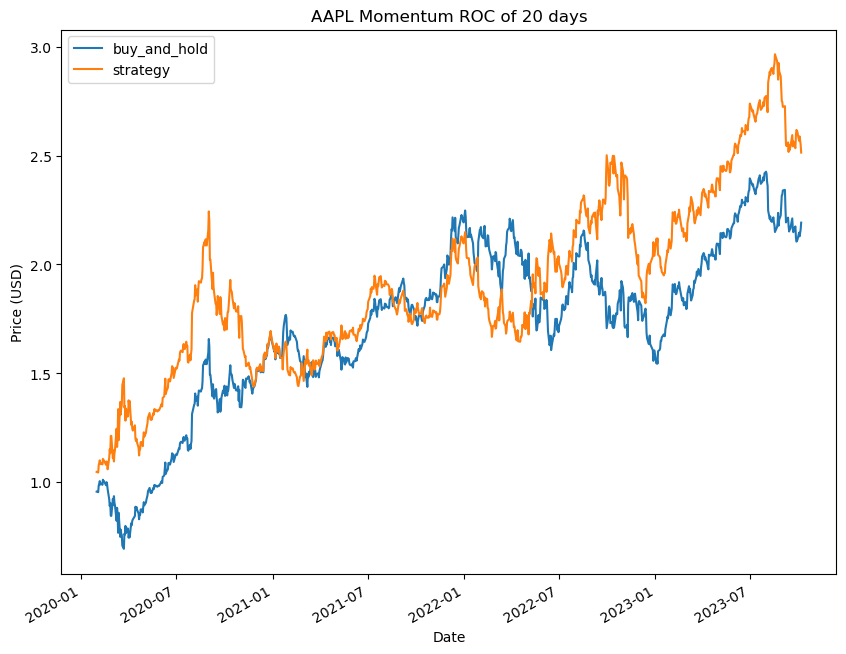

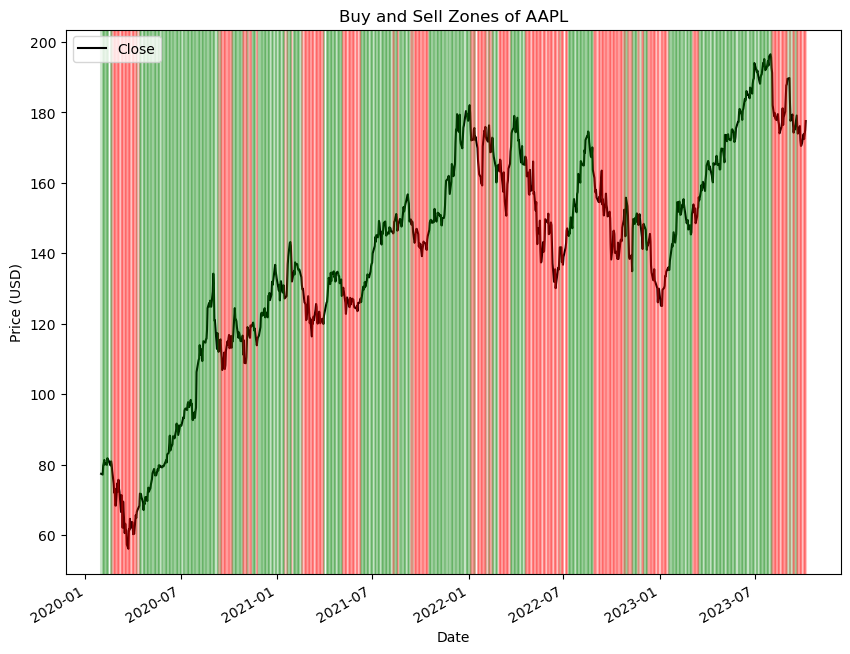

Note: ROC creates a "Zone-like" area of signals, hence the area to buy/sell is highlighted instead of plotting individual points.


In [8]:
aapl = MomentumROC("AAPL", 20, "2020-01-01")
aapl.performance_summary()
print("Note: ROC creates a \"Zone-like\" area of signals, hence the area to buy/sell is highlighted instead of plotting individual points." )

In [3]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = MomentumROC(symbol=ticker_symbol, period=20, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.117,0.210,0.298,0.518,0.411,0.648,-0.284,1.091,0.786,0.246,1.504,1.208,-0.037
ADBE,-0.117,-0.194,0.403,-0.110,-0.267,0.012,-0.439,0.981,-0.166,0.917,6.848,1.010,-0.051
AMD,-0.022,-0.038,0.551,0.231,-0.058,0.555,-0.383,1.039,0.354,0.553,1.377,1.067,-0.069
AMZN,-0.107,-0.178,0.441,-0.037,-0.233,0.349,-0.458,0.994,-0.054,0.248,3.520,1.006,-0.056
DIS,-0.135,-0.222,0.331,-0.272,-0.319,0.022,-0.424,0.955,-0.363,-0.825,4.854,1.043,-0.042
GOOGL,-0.330,-0.499,0.361,-0.926,-0.660,0.680,-0.499,0.855,-1.231,-0.319,1.803,1.108,-0.047
HD,-0.070,-0.118,0.273,-0.131,-0.174,0.546,-0.403,0.978,-0.190,0.454,3.813,0.930,-0.034
JNJ,-0.114,-0.188,0.171,-0.617,-0.321,0.231,-0.354,0.899,-0.807,-0.556,3.515,0.889,-0.022
JPM,-0.092,-0.153,0.261,-0.238,-0.260,0.025,-0.353,0.961,-0.330,0.025,1.665,0.886,-0.033
MA,-0.107,-0.178,0.257,-0.312,-0.231,0.018,-0.464,0.948,-0.433,0.054,1.679,0.793,-0.033


In [ ]:
# Export to excel
compiled_data.to_csv('compiled_data_momentum.csv')

# 2 - Momentum with ROC & Relative Strength Index (RSI)

In [4]:
class MomentumRSI():

    def __init__(self, symbol, roc_period, rsi_period, start, end= datetime.datetime.now(), ):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.roc_period = roc_period
        self.rsi_period = rsi_period
        self.get_data()

    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()
        
        # calculate RSI
        data.ta.rsi(length = self.rsi_period, close=data["Close"], append=True, append_to_df=True)
        
        # calculate momentum
        data["ROC"] = ((data["Close"] - data["Close"].shift(self.roc_period)) / data["Close"].shift(self.roc_period)) * 100

        # generate signals
        rsi_threshold = 40
        buysignals = data[(data["ROC"] > 0) & (data[f"RSI_{self.rsi_period}"] < rsi_threshold)]
        sellsignals = data[(data["ROC"] < 0) & (data[f"RSI_{self.rsi_period}"] > 100 - rsi_threshold)]

        # position
        data["position"] = np.where(data["ROC"] > 0 & (data[f"RSI_{self.rsi_period}"] < rsi_threshold), 1, -1)

        # buy_and_hold
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy returns
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals

    def performance_summary(self):

        # calculate sum of returns
        print("Sum of returns:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Momentum ROC of {self.roc_period} & RSI of {self.rsi_period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        # Conditional coloring of the graph based on buy/sell signals
        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="g", s=30, zorder=2)
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="r", s=30, zorder=2)

        plt.title(f"Buy and Sell Zones of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")
        plt.legend()
        plt.show()

In [5]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = MomentumRSI(symbol=ticker_symbol, roc_period = 14, rsi_period=7, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.181,0.338,0.301,0.701,0.740,0.868,-0.244,1.126,1.032,-0.016,1.668,1.065,-0.037
ADBE,0.186,0.349,0.405,0.621,0.584,0.723,-0.319,1.113,0.960,0.848,6.471,1.048,-0.050
AMD,-0.093,-0.157,0.556,0.100,-0.143,0.339,-0.650,1.017,0.149,0.407,1.329,1.081,-0.070
AMZN,0.085,0.155,0.440,0.406,0.215,0.663,-0.397,1.072,0.591,0.100,3.475,1.059,-0.055
DIS,-0.257,-0.406,0.330,-0.734,-0.530,0.483,-0.485,0.883,-0.955,-0.806,4.723,0.937,-0.043
GOOGL,-0.277,-0.434,0.361,-0.718,-0.588,0.325,-0.471,0.886,-0.951,-0.396,1.776,0.974,-0.046
HD,-0.269,-0.423,0.273,-1.012,-0.481,0.870,-0.560,0.840,-1.383,0.418,3.839,0.823,-0.036
JNJ,-0.103,-0.174,0.172,-0.546,-0.373,0.362,-0.277,0.910,-0.722,-0.523,3.430,0.982,-0.022
JPM,-0.003,-0.006,0.260,0.117,-0.010,0.176,-0.331,1.020,0.166,0.074,1.668,0.974,-0.033
MA,0.157,0.291,0.266,0.681,0.859,0.765,-0.182,1.125,0.984,-0.144,2.783,1.050,-0.033


In [ ]:
# Export to excel
compiled_data.to_csv('compiled_data_momentum_rsi.csv')

[*********************100%***********************]  1 of 1 completed
Sum of returns:
buy_and_hold    0.830218
strategy        1.006458
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-02-03      0.997254  1.002754
2020-02-04      1.030177  1.035858
2020-02-05      1.038577  1.044305
2020-02-06      1.050725  1.056520
2020-02-07      1.033989  1.039692
...                  ...       ...
2023-10-02      2.245485  2.794785
2023-10-03      2.228038  2.816670
2023-10-04      2.244322  2.796233
2023-10-05      2.260476  2.776250
2023-10-06      2.293819  2.735894

[927 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-02-03
End date,2023-10-06
Total months,44
,Backtest
Annual return,23.9%
Cumulative returns,119.9%
Annual volatility,34.5%
Sharpe ratio,0.79
Calmar ratio,0.63
Stability,0.80
Max drawdown,-38.0%


##################################################


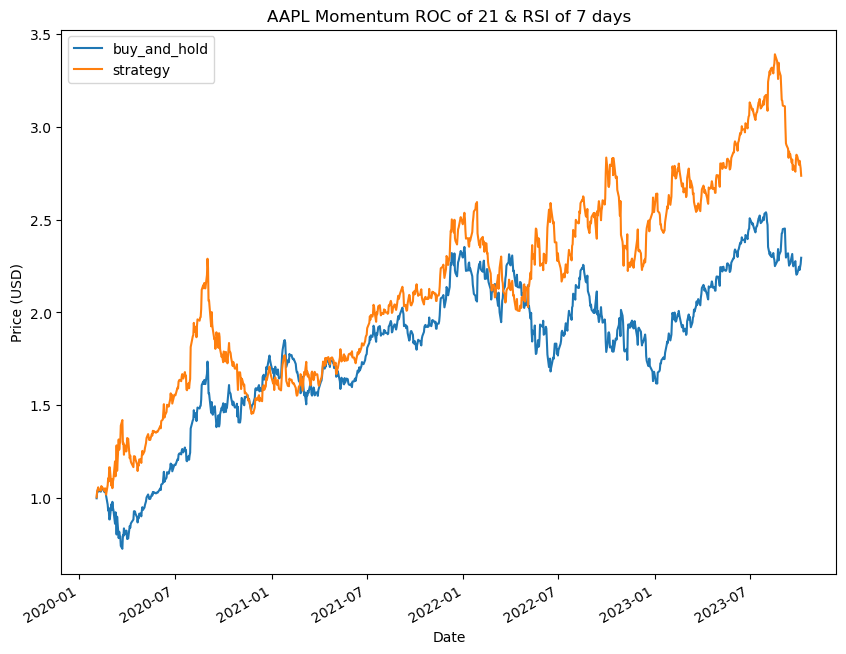

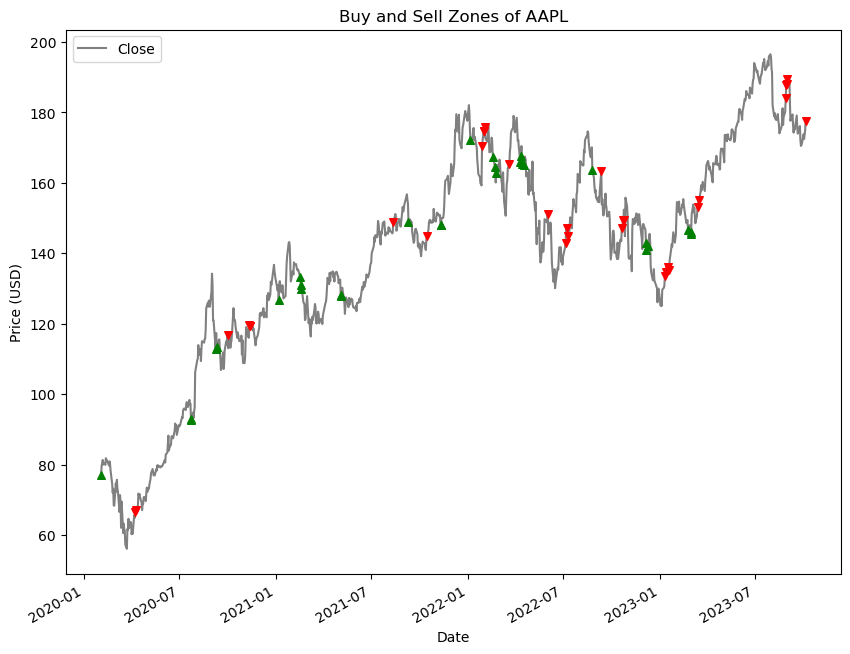

In [12]:
aapl = MomentumRSI("AAPL", roc_period=21, rsi_period=7, start="2020-01-01")
aapl.performance_summary()

# 3. Momentum Strategy with ROC & Stochastic Oscillator

In [6]:
class MomentumStochastic():

    def __init__(self, symbol, roc_period, stochastic_period, start, end= datetime.datetime.now(), ):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.roc_period = roc_period
        self.stochastic_period = stochastic_period
        self.get_data()
    
    def get_data(self):
            
            # extract data
            data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, ["High", "Low", "Close"]]
            
            # calculate momentum
            data["ROC"] = ((data["Close"] - data["Close"].shift(self.roc_period)) / data["Close"].shift(self.roc_period)) * 100
    
            # calculate stochastic
            data.ta.stoch(length=self.stochastic_period, append=True, append_to_df=True)
    
            # generate signals
            stocastic_threshold = 30
            roc_threshold = 0
            buysignals = data[(data["ROC"] > roc_threshold) & (data["STOCHk_14_3_3"] < stocastic_threshold)]
            sellsignals = data[(data["ROC"] < roc_threshold) & (data["STOCHk_14_3_3"] > 100 - stocastic_threshold)]
    
            # position
            data["position"] = np.where(data["ROC"] > roc_threshold & (data["STOCHk_14_3_3"] < stocastic_threshold), 1, -1)
    
            # buy_and_hold
            data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))
    
            # strategy returns
            data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]
    
            # drop na
            data.dropna(inplace=True)
    
            # set date as index
            data.reset_index(inplace=True)
            data.set_index('Date', inplace=True)
    
            # assign to self
            self.data = data
            self.buysignals = buysignals
            self.sellsignals = sellsignals
    
            return data, buysignals, sellsignals

    def performance_summary(self):

        # calculate sum of returns
        print("Sum of returns:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Momentum ROC of {self.roc_period} & Stochastic Oscillator of {self.stochastic_period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        # Conditional coloring of the graph based on buy/sell signals
        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="g", s=30, zorder=2)
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="r", s=30, zorder=2)

        plt.title(f"Buy and Sell Zones of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")
        plt.legend()
        plt.show()

In [7]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = MomentumStochastic(symbol=ticker_symbol, roc_period=21, stochastic_period=3, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.041,0.071,0.299,0.282,0.179,0.583,-0.227,1.049,0.415,0.042,1.521,1.179,-0.037
ADBE,-0.226,-0.357,0.403,-0.435,-0.434,0.278,-0.520,0.927,-0.639,0.891,6.909,1.029,-0.052
AMD,-0.194,-0.310,0.552,-0.118,-0.420,0.238,-0.461,0.981,-0.176,0.558,1.423,1.032,-0.070
AMZN,-0.175,-0.283,0.441,-0.216,-0.381,0.397,-0.460,0.964,-0.307,0.174,3.518,0.978,-0.056
DIS,-0.119,-0.197,0.331,-0.217,-0.252,0.010,-0.473,0.964,-0.290,-0.817,4.856,1.015,-0.042
GOOGL,-0.360,-0.537,0.361,-1.052,-0.670,0.701,-0.537,0.837,-1.361,-0.470,1.757,0.978,-0.047
HD,-0.006,-0.010,0.273,0.114,-0.018,0.332,-0.328,1.020,0.166,0.415,3.773,0.952,-0.034
JNJ,0.004,0.007,0.172,0.110,0.019,0.005,-0.221,1.019,0.150,-0.514,3.607,0.993,-0.022
JPM,-0.168,-0.272,0.261,-0.573,-0.400,0.271,-0.420,0.908,-0.757,-0.355,1.625,0.861,-0.033
MA,-0.246,-0.386,0.257,-0.971,-0.532,0.207,-0.463,0.847,-1.302,0.016,1.695,0.755,-0.033


In [ ]:
# Export to excel
compiled_data.to_csv('compiled_data_momentum_stoch.csv')

[*********************100%***********************]  1 of 1 completed
Sum of returns:
buy_and_hold    0.830218
strategy        1.006458
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-02-03      0.997254  1.002754
2020-02-04      1.030177  1.035858
2020-02-05      1.038577  1.044305
2020-02-06      1.050725  1.056520
2020-02-07      1.033989  1.039692
...                  ...       ...
2023-10-02      2.245485  2.794785
2023-10-03      2.228038  2.816670
2023-10-04      2.244322  2.796233
2023-10-05      2.260476  2.776250
2023-10-06      2.293819  2.735894

[927 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-02-03
End date,2023-10-06
Total months,44
,Backtest
Annual return,23.9%
Cumulative returns,119.9%
Annual volatility,34.5%
Sharpe ratio,0.79
Calmar ratio,0.63
Stability,0.80
Max drawdown,-38.0%


##################################################


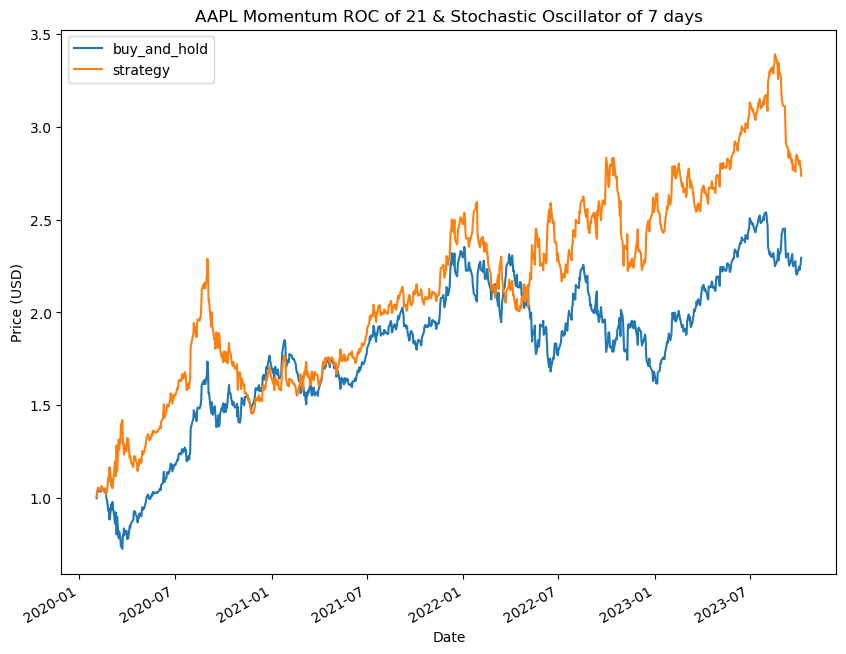

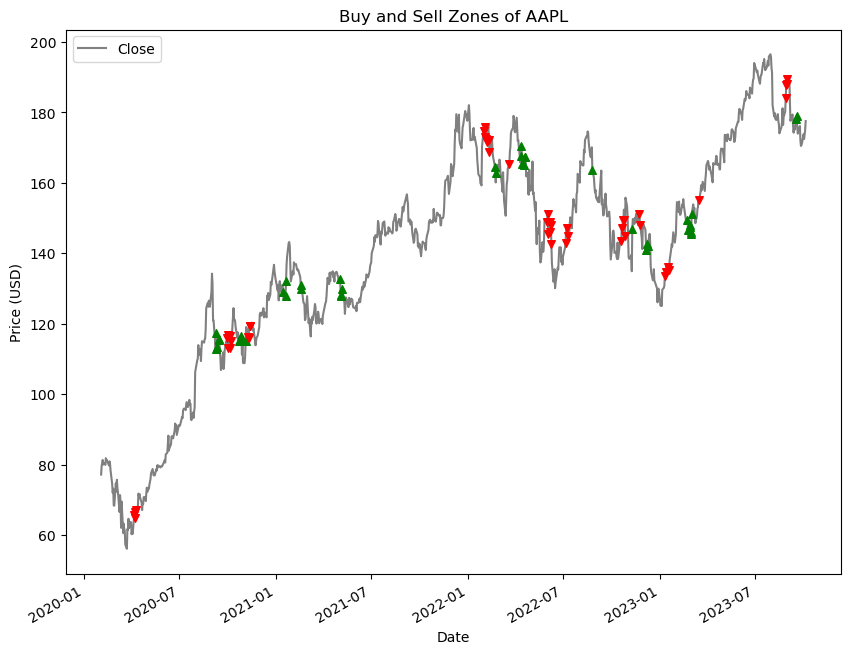

In [15]:
aapl = MomentumStochastic("AAPL", roc_period=21, stochastic_period=7, start="2020-01-01")
aapl.performance_summary()